# Lab - 9 BERT for multiple NLP Tasks: Telecom Data

## Lab Objectives

This lab focuses on applying BERT (Bidirectional Encoder Representations from Transformers) to analyze telecom customer service conversations. Through this practical session, you will learn how to leverage BERT for various NLP tasks specifically in the telecom domain.

### Dataset Description
The dataset contains customer service conversations between users and telecom company agents.

**Data Dictionary:**
- `sms`: SMS message
- `label`: 0 or 1
### Tasks Overview
1. **Data Preparation and Exploration**
   - Load and examine the conversation dataset
   - Perform basic text preprocessing
   - Prepare data for BERT input

2. **Sentence Similarity Analysis**
   - Implement BERT embeddings for sentences
   - Create similarity matrices for customer queries
   - Build a query matching system

3. **Document Clustering**
   - Generate BERT embeddings for entire conversations
   - Implement clustering algorithms
   - Analyze and visualize conversation clusters

4. **Text Classification**
   - Fine-tune BERT for category prediction
   - Evaluate classification performance
   - Analyze misclassified cases

In [ ]:
# ! pip install transformers --quiet

### Importing libraries

In [2]:
# Required imports
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings

warnings.filterwarnings('ignore')

### Dataset file

In [4]:
# Load the dataset
df = pd.read_csv('/content/SMS_spam_detection_train.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Columns:", df.columns.tolist())

Dataset Shape: (5574, 2)

Dataset Columns: ['sms', 'label']


In [5]:
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### Text processing function

In [6]:
def preprocess_text(text):
    """Basic preprocessing for BERT input"""
    # Convert to string in case of missing values
    text = str(text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Truncate to BERT's maximum sequence length (512 tokens)
    return text[:512]

In [7]:
# Apply preprocessing
df['process_text'] = df['sms'].apply(preprocess_text)

### Loading BERT model

In [8]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Sentence Similarity Analysis

#### Embdding function

In [9]:
def get_bert_embedding(text, tokenizer, model):
    """Generate BERT embedding for a given text"""
    # Tokenize and convert to tensor
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Use [CLS] token embedding as sentence representation
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

#### Functionfor similarity calculation

In [10]:
def calculate_similarity_matrix(messages):
    """Calculate similarity matrix for a list of messages"""
    embeddings = []
    for msg in messages:
        emb = get_bert_embedding(msg, tokenizer, model)
        embeddings.append(emb[0])

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix


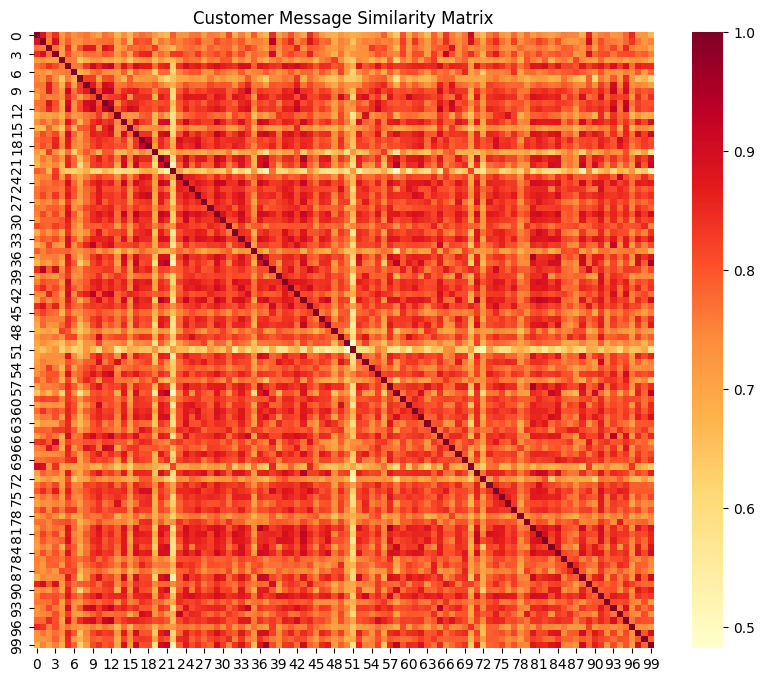

In [11]:
# Generate similarity matrix for a sample of customer messages
sample_messages = df['process_text'].head(100)
similarity_matrix = calculate_similarity_matrix(sample_messages)

# Visualize similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='YlOrRd')
plt.title('Customer Message Similarity Matrix')
plt.show()

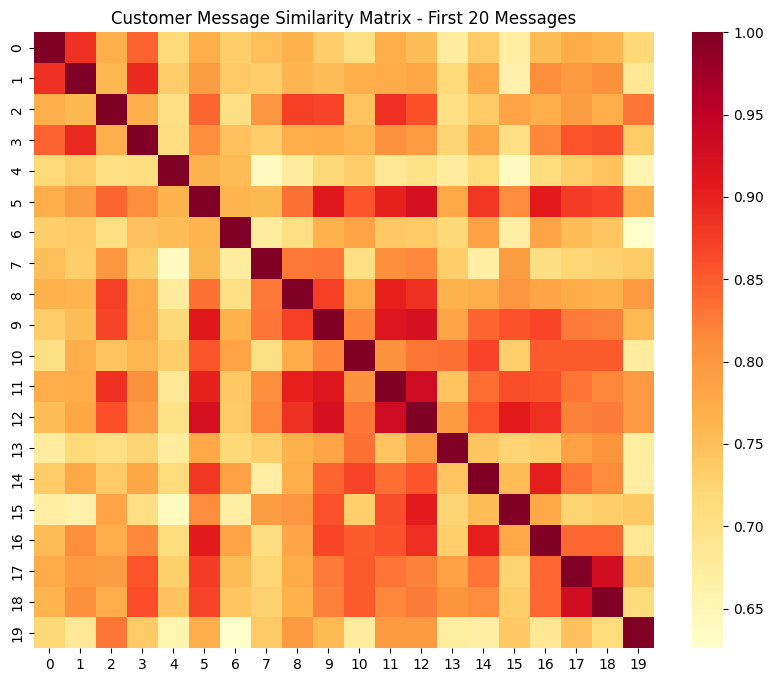

In [12]:
# Visualize similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix[:20, :20], cmap='YlOrRd')
plt.title('Customer Message Similarity Matrix - First 20 Messages')
plt.show()

### Document Clustering

In [13]:
# Generate embeddings for clustering
conversation_embeddings = []

for msg in df["process_text"]:  # Using a subset for demonstration
    emb = get_bert_embedding(msg, tokenizer, model)
    conversation_embeddings.append(emb[0])

In [14]:
K = 5
kmeans = KMeans(n_clusters=K,random_state=42).fit(conversation_embeddings)
cls_dist=pd.Series(kmeans.labels_).value_counts()

In [15]:
cls_dist

,count
1,1493
3,1378
4,1063
0,838
2,802


In [21]:
# !pip install umap-learn --quiet

In [22]:
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_,conversation_embeddings)
centers={}
print("Cluster", "Size", "Center-idx","Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, df['process_text'][ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		838		2942		My supervisor find 4 me one lor i thk his students. I havent ask her yet. Tell u aft i ask her.
1		1493		513		Lol ok your forgiven :)
2		802		389		4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths ? Call MobilesDirect free on 08000938767 to update now! or2stoptxt
3		1378		1881		Just seeing your missed call my dear brother. Do have a gr8 day.
4		1063		956		Sorry i now then c ur msg... Yar lor so poor thing... But only 4 one night... Tmr u'll have a brand new room 2 sleep in...


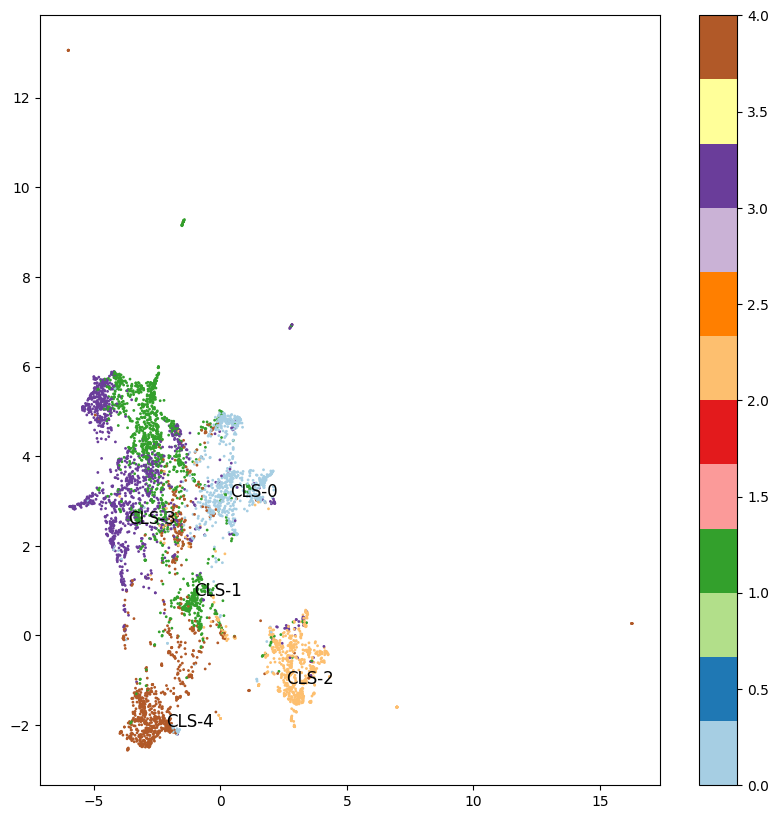

In [23]:
import matplotlib.pyplot as plt
import umap

X = umap.UMAP(n_components=2,min_dist=0.0).fit_transform(conversation_embeddings)
labels= kmeans.labels_
# print(labels)
fig, ax = plt.subplots(figsize=(10,10))
# print(X[:,0])\
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
for c in centers:
    plt.text(X[centers[c],0], X[centers[c], 1],"CLS-"+ str(c), fontsize=12)
plt.colorbar()

### Text Classification using Albert model

### Importing library

In [24]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import transformers
import random
# import chardet
import warnings

warnings.simplefilter('ignore')


In [25]:
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
def random_seed(SEED):

    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

SEED = 508
random_seed(SEED)

### Loading training file

In [51]:
data=pd.read_csv('/content/SMS_spam_detection_train.csv')
# data.columns=['text','lable']

display(data)
classes=sorted(data['label'].unique().tolist())

print(classes)
#
class_names=list('01')

N=list(range(len(class_names)))

normal_mapping=dict(zip(class_names,N))

reverse_mapping=dict(zip(N,class_names))

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


[0, 1]


### Train - Test split

In [28]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [29]:
#! pip install sentencepiece --quiet

### Loading tokenizer model

In [30]:
tokenizer = transformers.AlbertTokenizer.from_pretrained("albert-base-v2")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

### Encoding sentence

In [31]:
test_s = train['sms'].iloc[0]
result1 = tokenizer.encode_plus(test_s)
tokenizer.decode(result1["input_ids"])

"[CLS] free2day sexy st george's day pic of jordan!txt pic to 89080 dont miss out, then every wk a saucy celeb!4 more pics c pocketbabe.co.uk 0870241182716 £3/wk[SEP]"

In [32]:
len(test_s.split(" "))

26

In [33]:
result2 = tokenizer.encode_plus(
    test_s,
    add_special_tokens = True,
    max_length = 8,
    pad_to_max_length = True,
    truncation = True
)

In [34]:
tokenizer.decode(result2["input_ids"])

'[CLS] free2day sexy st george[SEP]'

In [35]:
max_sens = 8

train = train.sort_values('label').reset_index(drop=True)

train["kfold"] = train.index % 5

p_train = train[train["kfold"]!=0].reset_index(drop=True)
p_valid = train[train["kfold"]==0].reset_index(drop=True)

p_test=test.reset_index(drop=True)

### Data loaders

In [36]:
class BERTDataSet(Dataset):

    def __init__(self,sentences,targets):
        self.sentences = sentences
        self.targets = targets

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True,
                                max_length = max_sens,
                                pad_to_max_length = True,
                                return_attention_mask = True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)

        target = torch.tensor(self.targets[idx],dtype=torch.float)

        return {
                'ids': ids,
                'mask': mask,
                'targets': target
            }

In [37]:
train_dataset = BERTDataSet(p_train["sms"],p_train['label'])
valid_dataset = BERTDataSet(p_valid["sms"],p_valid['label'])
test_dataset = BERTDataSet(p_test["sms"],p_test['label'])

train_batch = 32
valid_batch = 32
test_batch = 32

train_dataloader = DataLoader(train_dataset,batch_size=train_batch,shuffle = True,num_workers=1,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch,shuffle = False,num_workers=1,pin_memory=True)
test_dataloader = DataLoader(test_dataset,batch_size=test_batch,shuffle = False,num_workers=1,pin_memory=True)

### Loading transformer model

In [38]:
model = transformers.AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=1)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model.to(device)
model.train()

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [40]:
# for a in train_dataloader:
#   print(a)
#   break

### loss function

In [41]:
def loss_fn(output,target):
    return torch.sqrt(nn.MSELoss()(output,target))

### Training function

In [42]:
def training(
    train_dataloader,
    model,
    optimizer,
    scheduler
):

    model.train()
    torch.backends.cudnn.benchmark = True
    allpreds = []
    alltargets = []

    for a in train_dataloader:

        losses = []
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():

            ids = a["ids"].to(device,non_blocking=True)
            mask = a["mask"].to(device,non_blocking=True)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            target = a["targets"].to(device,non_blocking=True)
            loss = loss_fn(output,target)

            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        del loss

        scheduler.step()

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    losses = np.mean(losses)
    train_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return losses,train_rme_loss

### Validation function

In [43]:
def validating(valid_dataloader,model):

    model.eval()
    allpreds = []
    alltargets = []

    for a in valid_dataloader:
        losses = []
        with torch.no_grad():

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            target = a["targets"].to(device)
            loss = loss_fn(output,target)
            losses.append(loss.item())
            allpreds.append(output.detach().cpu().numpy())
            alltargets.append(target.detach().squeeze(-1).cpu().numpy())

            del loss

    allpreds = np.concatenate(allpreds)
    alltargets = np.concatenate(alltargets)
    losses = np.mean(losses)
    valid_rme_loss = np.sqrt(mean_squared_error(alltargets,allpreds))

    return allpreds,losses,valid_rme_loss

### Setting up optimizer

In [44]:
from transformers import AdamW
LR=2e-5
optimizer = AdamW(model.parameters(), LR,betas=(0.9, 0.999), weight_decay=1e-2)

### Training process

In [45]:
from transformers import get_linear_schedule_with_warmup
epochs = 20
#if debug:
#    epochs = 1
train_steps = int(len(p_train)/train_batch*epochs)
print(train_steps)
num_steps = int(train_steps*0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

2229


In [46]:
trainlosses = []
vallosses = []
bestscore = None
trainscores = []
validscores = []

for epoch in tqdm(range(epochs)):

    print("---------------" + str(epoch) + "start-------------")

    trainloss,trainscore = training(train_dataloader,model,optimizer,scheduler)
    trainlosses.append(trainloss)
    trainscores.append(trainscore)

    print("trainscore is " + str(trainscore))

    preds,validloss,valscore=validating(valid_dataloader,model)
    vallosses.append(validloss)
    validscores.append(valscore)

    print("valscore is " + str(valscore))

    if bestscore is None:
        bestscore = valscore

        print("Save first model")

        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }

        # torch.save(state, "model0.pth")

    elif bestscore > valscore:

        bestscore = valscore
        print("found better point")
        state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }

        # torch.save(state, "model0.pth")

    else:
        pass

  0%|          | 0/20 [00:00<?, ?it/s]

---------------0start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.4087607121011773


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
  5%|▌         | 1/20 [00:06<02:12,  6.95s/it]

valscore is 0.28304820591874
Save first model
---------------1start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.24920224520761008


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 10%|█         | 2/20 [00:14<02:07,  7.10s/it]

valscore is 0.22089321255090857
found better point
---------------2start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.20986714596959707


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 15%|█▌        | 3/20 [00:19<01:49,  6.43s/it]

valscore is 0.21114626020292077
found better point
---------------3start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.1728493911261948


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 20%|██        | 4/20 [00:26<01:47,  6.69s/it]

valscore is 0.19974425139229823
found better point
---------------4start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.15867641084687495


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 25%|██▌       | 5/20 [00:32<01:35,  6.34s/it]

valscore is 0.18946683971669548
found better point
---------------5start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.14139406852521041


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 30%|███       | 6/20 [00:39<01:32,  6.57s/it]

valscore is 0.20773791322711216
---------------6start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.1350926632776789


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 35%|███▌      | 7/20 [00:45<01:21,  6.29s/it]

valscore is 0.21506772071235342
---------------7start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.12558646016583166


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 40%|████      | 8/20 [00:55<01:30,  7.55s/it]

valscore is 0.22019882313039646
---------------8start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.13435661057016016


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 45%|████▌     | 9/20 [01:01<01:16,  6.98s/it]

valscore is 0.2045208671300769
---------------9start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.10966269513542974


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 50%|█████     | 10/20 [01:08<01:10,  7.01s/it]

valscore is 0.25131019355191786
---------------10start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.12098788432919319


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 55%|█████▌    | 11/20 [01:14<00:59,  6.61s/it]

valscore is 0.2102176782108055
---------------11start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.10014320360721626


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 60%|██████    | 12/20 [01:20<00:53,  6.64s/it]

valscore is 0.20623825357684303
---------------12start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.10308726769182125


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 65%|██████▌   | 13/20 [01:26<00:44,  6.40s/it]

valscore is 0.2088512370902162
---------------13start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.09691027875692096


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 70%|███████   | 14/20 [01:32<00:38,  6.38s/it]

valscore is 0.20924402310780776
---------------14start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.09375087916438814


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 75%|███████▌  | 15/20 [01:39<00:32,  6.46s/it]

valscore is 0.20889819676776866
---------------15start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.09484380172149907


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 80%|████████  | 16/20 [01:45<00:24,  6.24s/it]

valscore is 0.21204073587449307
---------------16start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.09444767414043087


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 85%|████████▌ | 17/20 [01:52<00:19,  6.47s/it]

valscore is 0.2078543800087049
---------------17start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.0897495460053812


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 90%|█████████ | 18/20 [01:58<00:12,  6.23s/it]

valscore is 0.2078390645852772
---------------18start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.09062187501846904


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 95%|█████████▌| 19/20 [02:05<00:06,  6.55s/it]

valscore is 0.20773112561000398
---------------19start-------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


trainscore is 0.08919293572983909


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
100%|██████████| 20/20 [02:11<00:00,  6.55s/it]

valscore is 0.20738852460894472


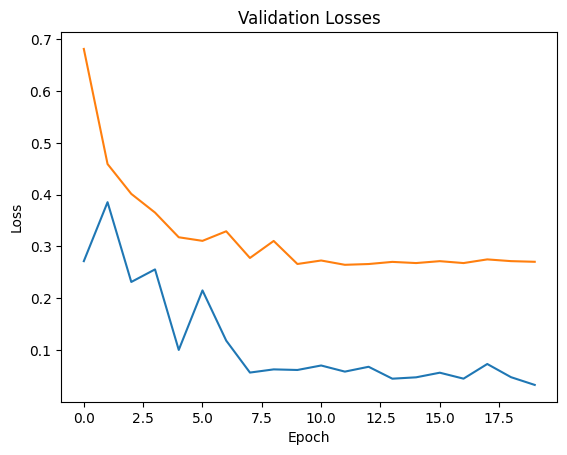

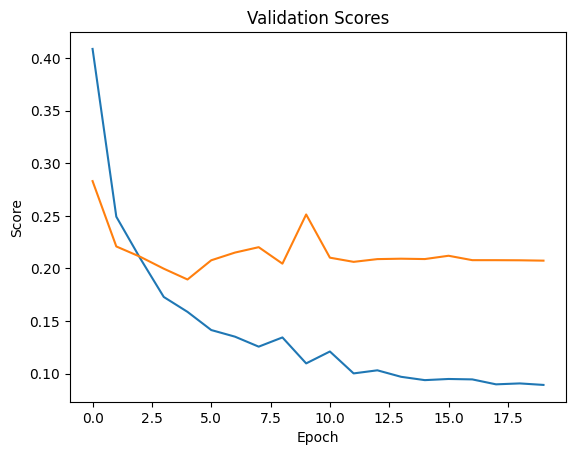

In [59]:
# plt.scatter(p_valid['label'],preds, alpha=0.2)
# plt.title('Validation Prediction Result')
# plt.xlabel('Actual')
# plt.ylabel('Prediction')
# plt.show()

x = np.arange(epochs)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trainlosses)
plt.plot(x,vallosses)
plt.show()

x = np.arange(epochs)
plt.title('Validation Scores')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.plot(x,trainscores)
plt.plot(x,validscores)
plt.show()

In [49]:
p_valid

,sms,label,kfold
0,Spoke with uncle john today. He strongly feels...,0,0
1,It wont b until 2.15 as trying 2 sort house ou...,0,0
2,Once free call me sir.\n,0,0
3,Come to mahal bus stop.. &lt;DECIMAL&gt;\n,0,0
4,Headin towards busetop\n,0,0
...,...,...,...
887,Do you want 750 anytime any network mins 150 t...,1,0
888,SMS. ac Blind Date 4U!: Rodds1 is 21/m from Ab...,1,0
889,You have 1 new voicemail. Please call 08719181...,1,0
890,Congratulations ur awarded 500 of CD vouchers ...,1,0


### Validation classification report


In [52]:
val_true = p_valid['label']
val_pred = []
for p in preds:
    val_pred+=[round(p,0)]

from sklearn.metrics import classification_report
print(classification_report(val_true,val_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

           0     0.9577    0.9923    0.9747       775
           1     0.9326    0.7094    0.8058       117

    accuracy                         0.9552       892
   macro avg     0.9451    0.8508    0.8902       892
weighted avg     0.9544    0.9552    0.9525       892



### Prediction on test dataset

In [53]:
def predicting(test_dataloader,model):

    model.to(device)
    model.eval()
    allpreds = []
    preds = []
    allvalloss=0

    with torch.no_grad():
        for a in test_dataloader:

            ids = a["ids"].to(device)
            mask = a["mask"].to(device)

            output = model(ids,mask)
            output = output["logits"].squeeze(-1)
            preds.append(output.cpu().numpy())

        preds = np.concatenate(preds)
        allpreds.append(preds)

    return allpreds

In [54]:
tpreds = predicting(test_dataloader, model)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [57]:
# tpreds

### Prediction classification report

In [56]:
test_true = p_test['label']
test_pred = []
for p in tpreds[0]:
    test_pred+=[round(p,0)]

from sklearn.metrics import classification_report
print(classification_report(test_true,test_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

           0     0.9613    0.9885    0.9747       954
           1     0.9179    0.7640    0.8339       161

    accuracy                         0.9561      1115
   macro avg     0.9396    0.8762    0.9043      1115
weighted avg     0.9550    0.9561    0.9543      1115

